In [1]:
# cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"
# indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/top"
# clone_order_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/clones_ranked/cloneID_rank_ncells.txt"

# cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"
# indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/donor0"
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/top/scrap"
# clone_order_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/clones_ranked/cloneID_rank_ncells.txt"

cells_meta_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"
indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/donor0"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/top" 
clone_order_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/clones_ranked/cloneID_rank_ncells.txt"
#ntop_clones = 8 
af_thresh = 0.001 
cov_thresh = 2 
ntop_vars = 10


ntop_clones = -1 #unused parameters

# af_thresh = 0.001
# cov_thresh = 2
# ntop_vars=10

remove_donor_vars = True

In [2]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

plt.rcParams['svg.fonttype'] = 'none'

fig_utils from mplh
0.5.6


In [3]:
from scipy.stats import mannwhitneyu

In [4]:
import seaborn as sns
from mplh import cluster_help as ch
from src.utils.data_io import reverse_ids


In [5]:
clone_order = pd.read_csv(clone_order_f, header=None)[0].values
top_clones = clone_order #clone_order[:ntop_clones]
top_clones

array(['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_9',
       '0_8', '0_10', '0_11', '0_13', '0_15', '0_12', '0_16', '0_17',
       '0_20', '0_18', '0_19', '0_21', '0_22', '0_23', '0_25', '0_28',
       '0_27', '0_29', '0_30', '0_31', '0_32', '0_33', '0_34', '0_14',
       '0_26', '0_35', '0_24'], dtype=object)

In [6]:
clone_order

array(['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_9',
       '0_8', '0_10', '0_11', '0_13', '0_15', '0_12', '0_16', '0_17',
       '0_20', '0_18', '0_19', '0_21', '0_22', '0_23', '0_25', '0_28',
       '0_27', '0_29', '0_30', '0_31', '0_32', '0_33', '0_34', '0_14',
       '0_26', '0_35', '0_24'], dtype=object)

In [7]:
#af_indir = join(indir, "sc_af", f"donor{DONOR}")
af_indir = indir

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")


#out_f = join(outdir, f"donor{DONOR}")


In [8]:
#donor_vars = AF_df>0.9

In [9]:
cells_meta = pd.read_csv(cells_meta_f,sep="\t", index_col=0)
cells_meta = reverse_ids(cells_meta)
cells_meta

,cloneID,clusterID,condition,donor
AAACGAAGTCTGATTG-1_Flt3l,0_2,HSPC 3,Flt3l,0
AAAGGGCAGACTTCCA-1_Flt3l,0_13,Classical Monocyte,Flt3l,0
AAATGAGGTATCCTTT-1_Flt3l,0_18,Non-classical monocyte,Flt3l,0
AAATGCCGTGATAAGT-1_Flt3l,0_6,Classical Monocyte,Flt3l,0
AACAAAGGTGCGACCT-1_Flt3l,0_1,Neutrophil,Flt3l,0
...,...,...,...,...
TTTGTGTGTAGGGTCA-1_Input,0_26,HSPC 1,Input,0
TTTGTGTGTTTCTTAC-1_Input,0_1,HSPC 1,Input,0
TTTGTGTTCCTGAAAC-1_Input,0_27,MkP,Input,0
TTTGTGTTCGGGAAAC-1_Input,0_19,HSPC 1,Input,0


## Get donor-specific variants

In [10]:
def get_high_variants(df, thresh, pct_thresh):
    """ Remove rows that have an average higher than threshold

    :param df:
    :param thresh:
    :return:
    """
    n_pct = pct_thresh*df.shape[0]
    return df.loc[:,((df>thresh).sum()>n_pct)].columns.values


donor_vars = get_high_variants(AF_df, thresh=0.8, pct_thresh=0.9)
print(f"number of donor vars: {len(donor_vars)}")


number of donor vars: 1


## Filter for clone

In [11]:
AF_df = AF_df.transpose()
DP_df = DP_df.transpose()

In [12]:
AF_df.head()

Cell,AAACGAAAGACGCCAA-1_Input,AAACGAACACGCTCAG-1_Input,AAACGAAGTACCAAGG-1_Input,AAACGAAGTCTGATTG-1_Flt3l,AAACGAAGTTCTCGAA-1_Input,AAACGAAGTTTGACCA-1_Input,AAACTCGCAACAACTC-1_Input,AAACTCGCAAGGACCA-1_Input,AAACTCGCATCCCAAA-1_Input,AAACTCGGTACGGATG-1_Input,...,TTTGGTTTCTGATCCC-1_Input,TTTGTGTAGTTCGTTG-1_Input,TTTGTGTCACACATTG-1_Input,TTTGTGTGTAAGCCGA-1_Input,TTTGTGTGTAGATTAG-1_Input,TTTGTGTGTAGGGTCA-1_Input,TTTGTGTGTTTCTTAC-1_Input,TTTGTGTTCCTGAAAC-1_Input,TTTGTGTTCGGGAAAC-1_Input,TTTGTGTTCTGGCACG-1_Input
146A,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
709A,0.0,0.000000,0.0,0.0,0.0,0.025974,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.042553,0.0,0.0,0.0,0.000000,0.018868
930A,0.0,0.035714,0.0,0.0,0.0,0.000000,0.0,0.018018,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1413A,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1888A,0.0,0.017778,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.017391,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.019608,0.000000


## Remove donor-specific variants

In [13]:
if remove_donor_vars:
    # Remove Donor variannts
    AF_df = AF_df.loc[~(AF_df.index.isin(donor_vars))]
    DP_df = DP_df.loc[AF_df.index, AF_df.columns] 

# Figure: 1: barplot for each clone, where x=Variant, and the % of cells (and raw) in the clone that has the variant and % of cells from other clone with variant


In [14]:
top_cells_meta = cells_meta[cells_meta["cloneID"].isin(top_clones)] 
top_cells_meta

,cloneID,clusterID,condition,donor
AAACGAAGTCTGATTG-1_Flt3l,0_2,HSPC 3,Flt3l,0
AAAGGGCAGACTTCCA-1_Flt3l,0_13,Classical Monocyte,Flt3l,0
AAATGAGGTATCCTTT-1_Flt3l,0_18,Non-classical monocyte,Flt3l,0
AAATGCCGTGATAAGT-1_Flt3l,0_6,Classical Monocyte,Flt3l,0
AACAAAGGTGCGACCT-1_Flt3l,0_1,Neutrophil,Flt3l,0
...,...,...,...,...
TTTGTGTGTAGGGTCA-1_Input,0_26,HSPC 1,Input,0
TTTGTGTGTTTCTTAC-1_Input,0_1,HSPC 1,Input,0
TTTGTGTTCCTGAAAC-1_Input,0_27,MkP,Input,0
TTTGTGTTCGGGAAAC-1_Input,0_19,HSPC 1,Input,0


In [15]:
bin_AF_df = (AF_df > af_thresh) & (DP_df > cov_thresh)
bin_AF_df

Cell,AAACGAAAGACGCCAA-1_Input,AAACGAACACGCTCAG-1_Input,AAACGAAGTACCAAGG-1_Input,AAACGAAGTCTGATTG-1_Flt3l,AAACGAAGTTCTCGAA-1_Input,AAACGAAGTTTGACCA-1_Input,AAACTCGCAACAACTC-1_Input,AAACTCGCAAGGACCA-1_Input,AAACTCGCATCCCAAA-1_Input,AAACTCGGTACGGATG-1_Input,...,TTTGGTTTCTGATCCC-1_Input,TTTGTGTAGTTCGTTG-1_Input,TTTGTGTCACACATTG-1_Input,TTTGTGTGTAAGCCGA-1_Input,TTTGTGTGTAGATTAG-1_Input,TTTGTGTGTAGGGTCA-1_Input,TTTGTGTGTTTCTTAC-1_Input,TTTGTGTTCCTGAAAC-1_Input,TTTGTGTTCGGGAAAC-1_Input,TTTGTGTTCTGGCACG-1_Input
146A,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
709A,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
930A,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1413A,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1888A,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7485T,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7639T,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12283T,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16294T,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Create variant-clone (and non-clone) percent of cells in clone with variant

In [16]:
def calc_clone_pct(data, **kwargs):
    curr_AF_df = bin_AF_df.loc[:,data.index]
    other_curr_AF_df = bin_AF_df.loc[:, ~(bin_AF_df.columns.isin(data.index))]
    
    curr_AF_tot = curr_AF_df.sum(axis=1)
    curr_AF_pct = 100*curr_AF_tot/curr_AF_df.shape[1]
    
    other_curr_AF_tot = other_curr_AF_df.sum(axis=1)
    other_curr_AF_pct = 100*other_curr_AF_tot/other_curr_AF_df.shape[1]
        
    return pd.concat((pd.DataFrame(curr_AF_pct).rename({0:"clone_pct"}, axis=1),
               pd.DataFrame(other_curr_AF_pct).rename({0:"other_clone_pct"}, axis=1)),axis=1, 
             ignore_index=False).rename_axis("variant")
    

pct_clones_df = top_cells_meta.groupby("cloneID").apply(calc_clone_pct).reset_index()
pct_clones_df

,cloneID,variant,clone_pct,other_clone_pct
0,0_0,146A,0.000000,0.407332
1,0_0,709A,10.256410,6.488216
2,0_0,930A,10.023310,5.731743
3,0_0,1413A,0.932401,0.610998
4,0_0,1888A,13.519814,8.088449
...,...,...,...,...
2695,0_9,7485T,1.904762,0.877426
2696,0_9,7639T,7.619048,6.700346
2697,0_9,12283T,2.857143,7.365062
2698,0_9,16294T,3.809524,4.918905


## Rank variants for each clone by sorting by mannwhitneyu test of allele-frequency


In [17]:
def rank_unique_vars_clone_af(clone_cells):
    clones_af = AF_df.loc[:,clone_cells.index].fillna(0)
    other_clones_af = AF_df.loc[:, ~(AF_df.columns.isin(clone_cells.index))].fillna(0)
    pvals = mannwhitneyu(clones_af, other_clones_af, alternative='greater', axis=1).pvalue
    rankings = pd.DataFrame(index=clones_af.index,data=pvals).rank(method="min").rename({0:"rank"}, axis=1) # np.argsort(pvals)
    #print(type(rankings))
    #print('rankings', rankings)

    rankings["pval"] = pvals
    rankings["rank"]= rankings["rank"].astype('int')
    #print('rankings', rankings)
    #print('rankings', rankings.head())
    rankings.index.name = "variant"
    return rankings

pvals_df = cells_meta.groupby("cloneID").apply(rank_unique_vars_clone_af).reset_index()
pvals_df

,cloneID,variant,rank,pval
0,0_0,146A,60,0.866780
1,0_0,709A,13,0.001581
2,0_0,930A,9,0.000199
3,0_0,1413A,42,0.216821
4,0_0,1888A,7,0.000047
...,...,...,...,...
2695,0_9,7485T,9,0.136465
2696,0_9,7639T,18,0.352778
2697,0_9,12283T,69,0.959462
2698,0_9,16294T,40,0.717263


In [18]:
pct_pvals_df = pd.merge(pct_clones_df, pvals_df, on=["cloneID", "variant"])
pct_pvals_df

,cloneID,variant,clone_pct,other_clone_pct,rank,pval
0,0_0,146A,0.000000,0.407332,60,0.866780
1,0_0,709A,10.256410,6.488216,13,0.001581
2,0_0,930A,10.023310,5.731743,9,0.000199
3,0_0,1413A,0.932401,0.610998,42,0.216821
4,0_0,1888A,13.519814,8.088449,7,0.000047
...,...,...,...,...,...,...
2695,0_9,7485T,1.904762,0.877426,9,0.136465
2696,0_9,7639T,7.619048,6.700346,18,0.352778
2697,0_9,12283T,2.857143,7.365062,69,0.959462
2698,0_9,16294T,3.809524,4.918905,40,0.717263


In [19]:
def plot_pct_bar(data, **kwargs):
    ntop_vars = kwargs.get("ntop_vars", 0)
    data = data.set_index("variant")
    if ntop_vars != 0:
        data = data[data['rank']<ntop_vars].sort_values("rank")
        data[["clone_pct", "other_clone_pct"]].plot.bar(ax=plt.gca())
        plt.gca().set_ylabel("% cells with variant")
    else:
        data = data.loc[(data["clone_pct"]-data["other_clone_pct"]).sort_values()[::-1].index]
        #data = data.sort_values("clone_pct")[::-1]
        #print(data["clone_pct"]-data["other_clone_pct"])
        pd.DataFrame((data["clone_pct"]-data["other_clone_pct"])).plot.bar(ax=plt.gca())
        plt.gca().set_ylabel("(% cells in clone with variant) - (%cells not in clone with variant)")
    #plt.gca().legend(loc='best') 
    return

## Figure: Barplot of percent in clone vs percent not in clone

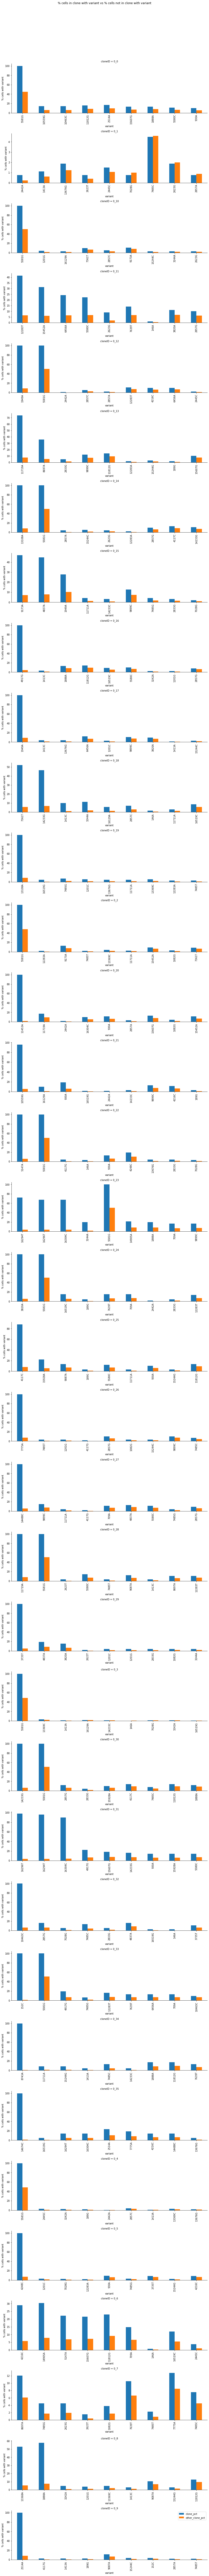

In [20]:
g = sns.FacetGrid(data=pct_pvals_df, col = "cloneID", col_wrap=1, height=4, aspect=3,
                 sharex=False, sharey=False)
g.map_dataframe(plot_pct_bar, ntop_vars=ntop_vars)
g.fig.suptitle("% cells in clone with variant vs % cells not in clone with variant", y=1.02)
#g.fig.savefig(fname=join(outdir, f"all_variants_distinct_pct_vs_other.pdf"), dpi=500, bbox_inches='tight', pad_inches=0.5)
g.fig.savefig(fname=join(outdir, f"all_variants_distinct_pct_vs_other.svg"), dpi=500, bbox_inches='tight', pad_inches=0.5)
g.fig.savefig(fname=join(outdir, f"all_variants_distinct_pct_vs_other.pdf"), dpi=500, bbox_inches='tight', pad_inches=0.5)


plt.tight_layout()
plt.legend()

In [21]:
def plot_violin(data, **kwargs):
    ntop_vars = kwargs.get("ntop_vars", 0)
    curr_clone = data["cloneID"].values[0]
    print('curr_clone', curr_clone)
    curr_AF_df = AF_df.loc[:,data.index]
    other_curr_AF_df = AF_df.loc[:, ~(AF_df.columns.isin(data.index))]
    
    curr_AF_df = curr_AF_df.reset_index().melt(id_vars='index', var_name="cell", value_name="AF")
    curr_AF_df["type"] = "clone"
    
    other_curr_AF_df = other_curr_AF_df.reset_index().melt(id_vars='index', var_name="cell", value_name="AF")
    other_curr_AF_df["type"] = "other"
    curr_merge_df = pd.concat((curr_AF_df, other_curr_AF_df), axis=0)
    curr_merge_df = curr_merge_df.rename({"index":"variant"}, axis=1)
    print(curr_merge_df.head())
    if ntop_vars != 0:
        print(pct_pvals_df[(pct_pvals_df["cloneID"]==curr_clone)])
        if pct_pvals_df[(pct_pvals_df["cloneID"]==curr_clone)].shape[0] == 0:
            return
        curr_top_vars = pct_pvals_df[(pct_pvals_df["cloneID"]==curr_clone) & (pct_pvals_df["rank"]<=ntop_vars)].sort_values("rank")["variant"].values
        print('top vars', curr_top_vars)
        #print('before top vars',curr_merge_df.shape)
        curr_merge_df = curr_merge_df[curr_merge_df["variant"].isin(curr_top_vars)] #data[data['rank']<ntop_vars].sort_values("rank")
        #print('after top vars',curr_merge_df.shape)
        
    sns.boxenplot(data=curr_merge_df, x="variant", y="AF", hue="type", ax=plt.gca())
    return 
    
    


# Plot variants as row and clone as x AF violin

In [22]:
def long_af(ser, cells_meta):
    v = ser.name
    cells_meta["Variant"] = v
    #print('ser', pd.DataFrame(ser))
    cells_meta  = pd.merge(pd.DataFrame(ser).rename({v:"af"}, axis=1), 
             cells_meta, left_index=True, right_index=True, how='inner' )
    #cells_meta.loc[ser.index, "AF"] = ser
    return cells_meta
    
long_af = AF_df.apply(long_af, cells_meta=cells_meta, axis=1)
long_af = pd.concat(long_af.values, axis=0)

In [23]:
vars_min_over_median = pct_pvals_df.groupby("variant").apply(lambda x: min(x['rank']+1)/np.median(x['rank']+1))
vars_min_over_median = vars_min_over_median.sort_values()
vars_order = vars_min_over_median.index
vars_min_over_median


variant
5581G     0.026316
4248C     0.028369
4917G     0.030769
1949A     0.031008
13108A    0.032258
            ...   
709A      0.166667
1082G     0.171429
14233C    0.179104
15244C    0.188679
7639T     0.218182
Length: 75, dtype: float64

In [24]:
print(len(vars_order))
vars_order = [x for x in vars_order if x in long_af["Variant"].values]
print(len(vars_order))
vars_order

75
75


['5581G',
 '4248C',
 '4917G',
 '1949A',
 '13108A',
 '16294T',
 '2514A',
 '11453A',
 '16296T',
 '11719A',
 '10559G',
 '8743A',
 '5147A',
 '13368A',
 '14233G',
 '152C',
 '4117C',
 '14674C',
 '3820A',
 '14488C',
 '3735T',
 '8697A',
 '10463C',
 '7361T',
 '12283T',
 '9173A',
 '2442A',
 '4216C',
 '7775A',
 '16304C',
 '1888A',
 '12283A',
 '1413A',
 '2445C',
 '1413C',
 '16519G',
 '4117G',
 '4837A',
 '15452A',
 '9899C',
 '7485T',
 '1201G',
 '16129A',
 '2857G',
 '11711A',
 '14905A',
 '1201C',
 '2623T',
 '15928A',
 '7485G',
 '2833G',
 '13369C',
 '930A',
 '15244G',
 '2623G',
 '6456A',
 '9087A',
 '7028G',
 '11812G',
 '16519C',
 '15607G',
 '2857A',
 '13676G',
 '3244A',
 '189G',
 '3242A',
 '5580C',
 '7485C',
 '2857C',
 '146A',
 '709A',
 '1082G',
 '14233C',
 '15244C',
 '7639T']

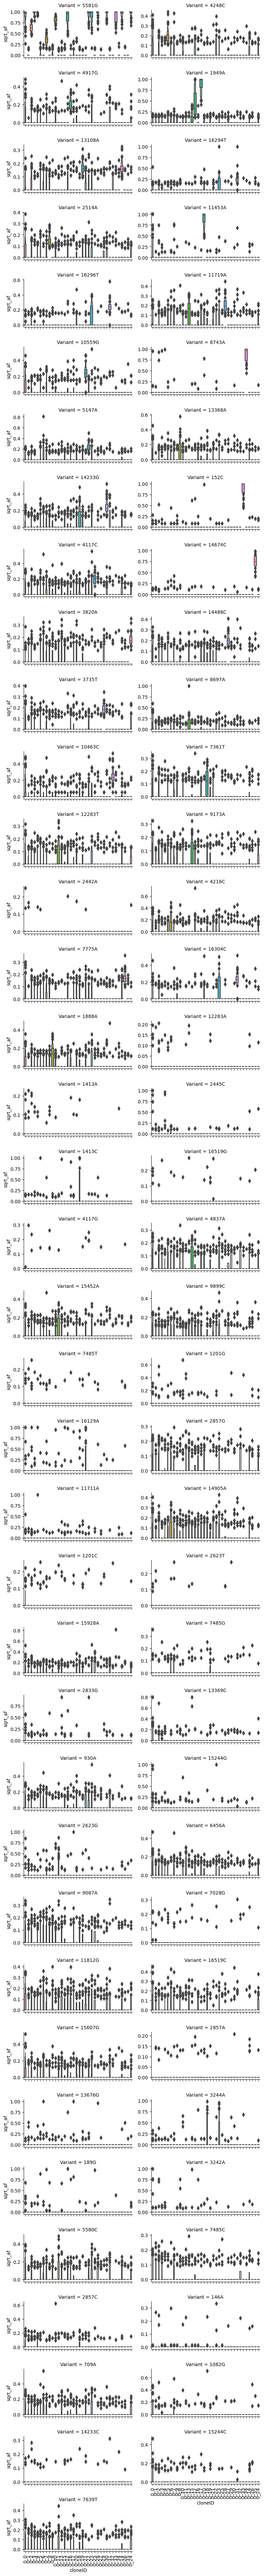

In [25]:
long_af["sqrt_af"] = np.sqrt(long_af["af"])
g = sns.catplot(data=long_af.reset_index(), x="cloneID", y="sqrt_af", col="Variant", col_wrap=2, kind='boxen', 
            sharey=False, col_order=vars_order,
            order=top_clones, height=2, aspect=2)

for ax in g.axes.flat: 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
g.fig.savefig(fname=join(outdir, 'sqrt_all_variants_af.pdf'), 
              bbox_inches='tight', pad_inches=0.5)

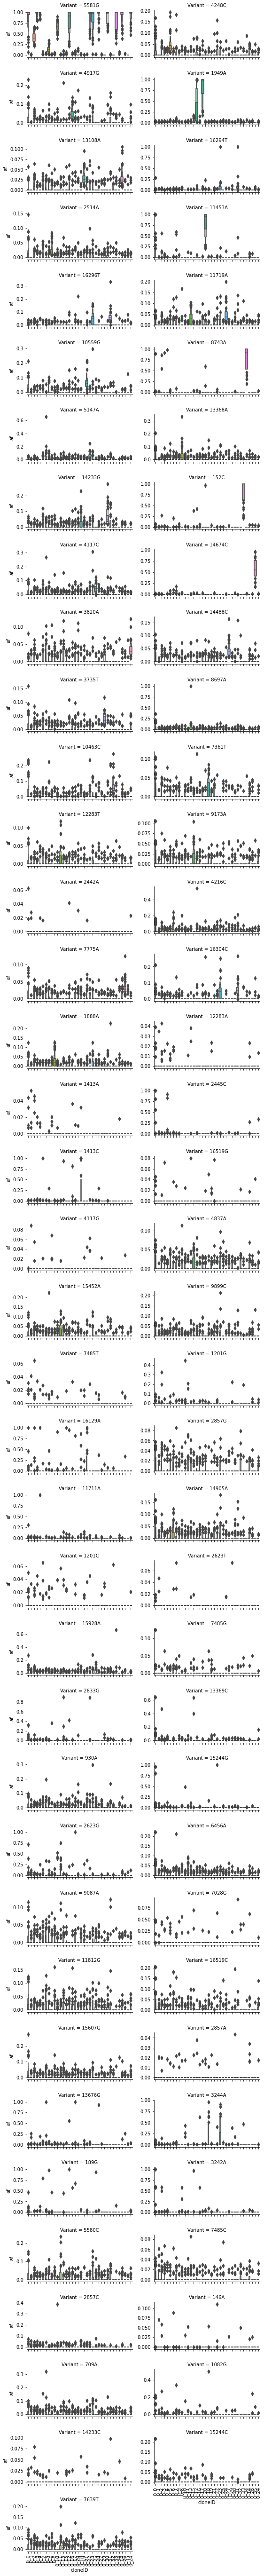

In [24]:

g = sns.catplot(data=long_af.reset_index(), x="cloneID", y="af", col="Variant", col_wrap=2, kind='boxen', 
            sharey=False, col_order=vars_order,
            order=top_clones, height=2, aspect=2)

for ax in g.axes.flat: 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
g.fig.savefig(fname=join(outdir, 'all_variants_af.pdf'), 
              bbox_inches='tight', pad_inches=0.5)

curr_vars 16 ['5581G', '4248C', '4917G', '1949A', '13108A', '16294T', '2514A', '11453A', '16296T', '11719A', '10559G', '8743A', '5147A', '13368A', '14233G', '152C']
curr_vars 16 ['4117C', '14674C', '3820A', '14488C', '3735T', '8697A', '10463C', '7361T', '12283T', '9173A', '2442A', '4216C', '7775A', '16304C', '1888A', '12283A']


KeyboardInterrupt: 

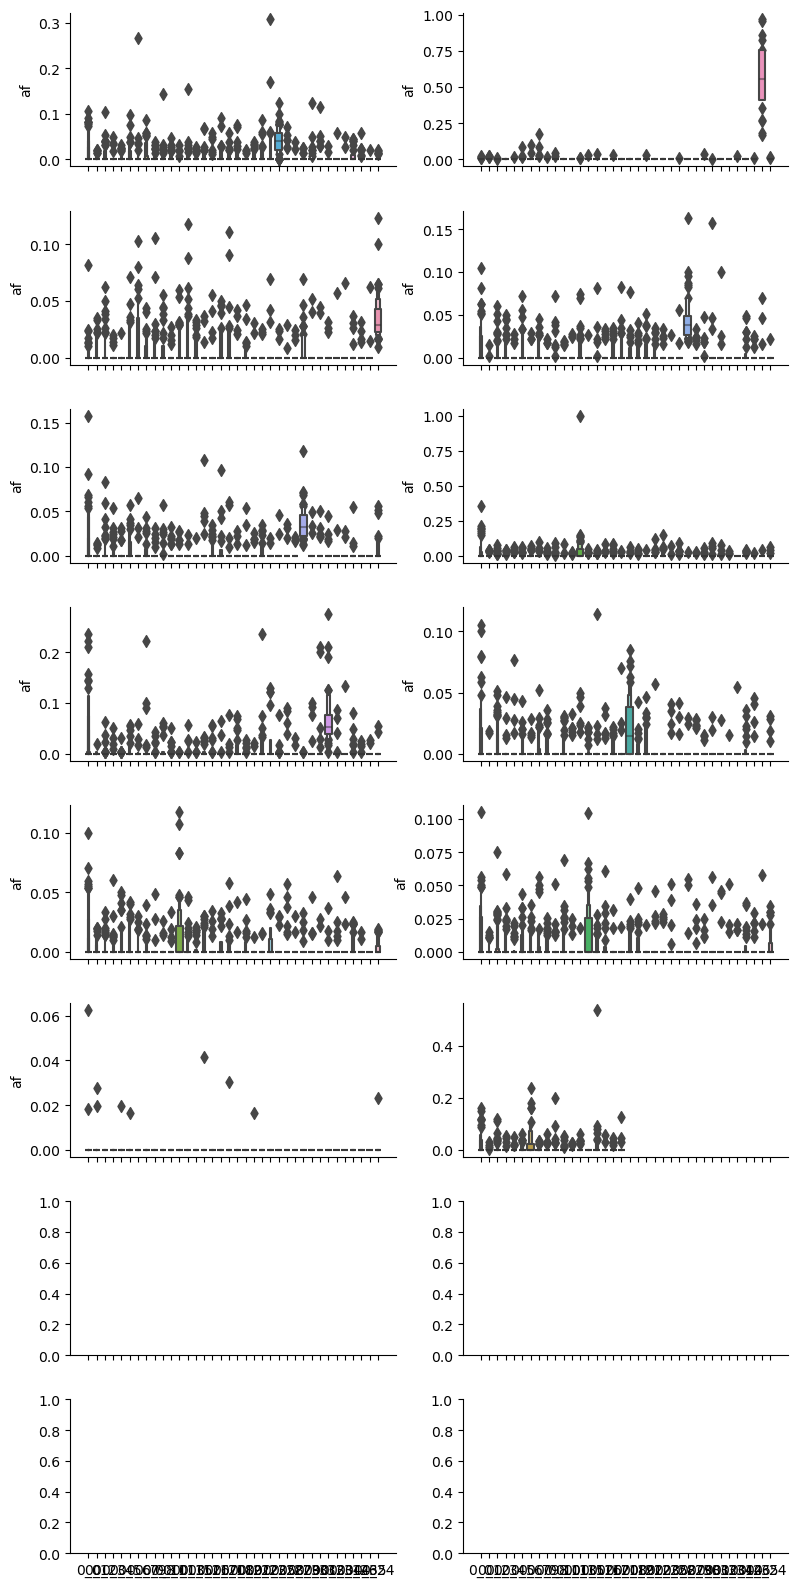

In [25]:
nvars = len(vars_order)
nfigs = int(np.round(nvars/16))
out_fs = []
for curr_f in range(nfigs):
    end_ind = min((curr_f+1)*16, nvars)
    curr_vars = vars_order[(curr_f*16):end_ind]
    print('curr_vars', len(curr_vars), curr_vars)
    curr_file = join(outdir, f"all_variants_{curr_f+1}_{(end_ind+1)}_af.svg")
    g = sns.catplot(data=long_af.reset_index(), x="cloneID", y="af", col="Variant", col_wrap=2, kind='boxen', 
                sharey=False, col_order=curr_vars,
                order=top_clones, height=2, aspect=2)
    for ax in g.axes.flat: 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    g.fig.savefig(fname=curr_file, bbox_inches='tight', pad_inches=0.5)
    out_fs.append(curr_file)
    plt.close()

In [27]:
# try:
#     g = sns.catplot(data=long_af, x="cloneID", y="af", col="Variant", col_wrap=2, kind='boxen', 
#                 sharey=False, col_order=vars_order,
#                 height=4, aspect=2, order=top_clones)
#     g.fig.savefig(fname=join(outdir, f"all_variants_af.svg"), dpi=500, bbox_inches='tight', pad_inches=0.5)
# except ValueError as e:

cmd = f"svg_stack.py --direction=h --margin=100 {' '.join(out_fs)} > {join(outdir, 'all_variants_af.svg')}"
print(cmd)
os.system(cmd)
    #!{cmd}

    #g.fig.savefig(fname=join(outdir, f"top_variants_af.pdf"), dpi=500, bbox_inches='tight', pad_inches=0.5)


svg_stack.py --direction=h --margin=100 /data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/top/all_variants_1_17_af.svg /data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/top/all_variants_2_33_af.svg /data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/top/all_variants_3_49_af.svg /data/Mito_Trace/output/pipeline/

0

In [28]:
outdir

'/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor0/cloneMethod_variants_prefilterMerge_impute_knn_resolution_30/clonalShift_method_clones/top'

In [29]:
long_af

,af,cloneID,clusterID,condition,donor,Variant
AAACGAACACGCTCAG-1_Input,0.0,0_2,MkP,Input,0,146A
AAACGAAGTACCAAGG-1_Input,0.0,0_12,HSPC 1,Input,0,146A
AAACGAAGTCTGATTG-1_Flt3l,0.0,0_2,HSPC 3,Flt3l,0,146A
AAACGAAGTTCTCGAA-1_Input,0.0,0_21,HSPC 2,Input,0,146A
AAACGAAGTTTGACCA-1_Input,0.0,0_14,HSPC 2,Input,0,146A
...,...,...,...,...,...,...
TTTGTGTGTAGGGTCA-1_Input,0.0,0_26,HSPC 1,Input,0,16296T
TTTGTGTGTTTCTTAC-1_Input,0.0,0_1,HSPC 1,Input,0,16296T
TTTGTGTTCCTGAAAC-1_Input,0.0,0_27,MkP,Input,0,16296T
TTTGTGTTCGGGAAAC-1_Input,0.0,0_19,HSPC 1,Input,0,16296T


In [32]:
# def min_vals(x):
#     #print(x)
#     return x.sort_values(["pval"])[:10]["variant"].values
#     #x.loc[x==x["pval"].min()].index
# top_clone_vars = pct_pvals_df.groupby("cloneID").apply(min_vals) #lambda x: x[x==x["pval"].min()].index)

# nvars = len(vars_order)
# nfigs = int(np.round(nvars/16))
# out_fs = []
# for curr_f in range(nfigs):
#     end_ind = min((curr_f+1)*16, nvars)
#     curr_vars = vars_order[(curr_f*16):end_ind]
#     print('curr_vars', len(curr_vars), curr_vars)
#     curr_file = join(outdir, f"all_variants_{curr_f+1}_{(end_ind+1)}_af_max.svg")
    
#     long_af["af"] = np.clip((long_af["af"]), 0, 0.6)
#     g = sns.catplot(data=long_af.reset_index(), x="cloneID", y="af", col="Variant", col_wrap=2, kind='boxen', 
#                 sharex=False, col_order=curr_vars, 
#                 height=2, aspect=2)
#     break
#     g.fig.savefig(fname=curr_file, bbox_inches='tight', pad_inches=0.5)
#     out_fs.append(curr_file)
#     plt.close()